In [ ]:
# ставим библиотеку: тихо, без кеша, чтобы точно взялся свежий wheel
!pip install --no-cache-dir --quiet "catboost==1.2.8"

# быстрая самопроверка прямо в той же ячейке

import catboost, numpy, sys
print("✔ CatBoost", catboost.__version__,
      "| NumPy", numpy.__version__,
      "| Python", sys.version.split()[0])



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 278.1 MB/s eta 0:00:00
✔ CatBoost 1.2.8 | NumPy 2.0.2 | Python 3.11.12


In [ ]:
# ================================================
# 0. ИМПОРТЫ (полный список, один раз в начале)
# ================================================
import pandas as pd
import numpy as np
from datetime import timedelta

# scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix

# catboost
from catboost import CatBoostClassifier, Pool

# визуализации
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:

# Чтобы выводы занимали меньше места
pd.set_option('display.max_columns', None)

# ================================================
# 1. ЧТЕНИЕ ДАННЫХ
# ================================================
# --- если файл загружен вручную ---
PATH = '/content/sample_data/master_grid_filtered_temp_fireperiod.csv'  # поправьте путь при необходимости
df = pd.read_csv(PATH, low_memory=False)

# 3. Переименование колонок для удобства
df = df.rename(columns={
    'Склад': 'warehouse',
    'Штабель': 'stack',
    'Дата': 'day',
    'Fire_Started_Today': 'fire'
})
df['Current_Weight_Tons'] = df['Current_Weight_Tons'] / 1000
df = df.rename(columns={'Current_Weight_Tons': 'Current_Weight_Kilotons'})

# 4. Приведение day к типу datetime и удаление строк без даты
df['day'] = pd.to_datetime(df['day'], errors='coerce')
df = df.dropna(subset=['day']).reset_index(drop=True)

# 5. Feature engineering
# 5.1 признаки из даты
df['dayofyear'] = df['day'].dt.dayofyear
df['month']     = df['day'].dt.month
df['year']      = df['day'].dt.year
df['weekday']   = df['day'].dt.weekday

# 5.2 Formation_Date → числовой признак
df['Formation_Date'] = pd.to_datetime(df['Formation_Date'], errors='coerce')
df['Formation_Date_ordinal'] = df['Formation_Date'].map(
    lambda x: x.toordinal() if pd.notnull(x) else np.nan
)

# 5.3 Days_Since_Last_Measurement → float
df['Days_Since_Last_Measurement'] = pd.to_numeric(
    df['Days_Since_Last_Measurement'], errors='coerce'
)

# 5.4 Временные признаки: лаги и скользящие
ts_cols = [
    't_mean','t_min','t_max',
    'p_mean','p_min','p_max',
    'humidity_mean','humidity_min',
    'Temp_Measure_Max',
    'Added_Today_Tons','Removed_Today_Tons',
    'Daily_Weight_Change','Current_Weight_Kilotons'
]

# сортируем по складу, штабелю и дате
df = df.sort_values(['warehouse','stack','day'])

for col in ts_cols:
    # лаги на 1,2,3 дня назад
    df[f'{col}_lag1'] = df.groupby(['warehouse','stack'])[col].shift(1)
    df[f'{col}_lag2'] = df.groupby(['warehouse','stack'])[col].shift(2)
    df[f'{col}_lag3'] = df.groupby(['warehouse','stack'])[col].shift(3)
    # скользящее среднее за 3 и 7 дней
    df[f'{col}_roll3'] = (
        df.groupby(['warehouse','stack'])[col]
          .rolling(window=3, min_periods=1)
          .mean()
          .reset_index(level=[0,1], drop=True)
    )
    df[f'{col}_roll7'] = (
        df.groupby(['warehouse','stack'])[col]
          .rolling(window=7, min_periods=1)
          .mean()
          .reset_index(level=[0,1], drop=True)
    )

# заполняем NaN в новых признаках медианой
lag_roll_cols = [c for c in df.columns if c.endswith(('lag1','lag2','lag3','roll3','roll7'))]
for c in lag_roll_cols:
    df[c] = df[c].fillna(df[c].median())

# 6. Подготовка X и y
target = 'fire'
y = df[target].astype(int)

# добавляем сезон по месяцу
seasons = {
    12:'зима',1:'зима',2:'зима',
     3:'весна',4:'весна',5:'весна',
     6:'лето',7:'лето',8:'лето',
     9:'осень',10:'осень',11:'осень'
}
df['season'] = df['day'].dt.month.map(seasons)

# колонки, которые не даём модели напрямую
drop_cols = [
    'day', 'Formation_Date', target,
    'weather_code_mode',
    'Daily_Weight_Change'
]
X = df.drop(columns=drop_cols)

# разделяем признаки на категориальные и числовые
categorical_features = ['warehouse', 'stack', 'season']
numerical_features   = [c for c in X.columns if c not in categorical_features]

# 7. Разбиение на train/test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,
    shuffle=False
)

# 8. Обучение моделей
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report

# 8.1 Pipeline для GradientBoosting (если нужно)
numeric_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median'))
])
categorical_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot',  OneHotEncoder(handle_unknown='ignore'))
])
preprocess = ColumnTransformer([
    ('num', numeric_pipe, numerical_features),
    ('cat', categorical_pipe, categorical_features)
])

# from sklearn.ensemble import GradientBoostingClassifier
# gb_model = Pipeline([
#     ('prep',  preprocess),
#     ('model', GradientBoostingClassifier(
#         random_state=42,
#         n_estimators=300,
#         learning_rate=0.05,
#         max_depth=3
#     ))
# ])
# gb_model.fit(X_train, y_train)
# print('\n=== GradientBoosting ===')
# print(classification_report(y_test, gb_model.predict(X_test)))

# 8.2 CatBoost (работает с категориальными из коробки)
from catboost import CatBoostClassifier, Pool

cat_features_idx = [X.columns.get_loc(c) for c in categorical_features]
cb_train = Pool(X_train, y_train, cat_features=cat_features_idx)
cb_test  = Pool(X_test,  y_test,  cat_features=cat_features_idx)

cb_model = CatBoostClassifier(
    iterations=16,
    learning_rate=0.2,
    depth=3,
    loss_function='Logloss',
    verbose=False,
    auto_class_weights='SqrtBalanced'
)
cb_model.fit(cb_train, eval_set=cb_test, verbose=100)

print('\n=== CatBoost Classification Report ===')
print(classification_report(y_test, cb_model.predict(cb_test)))

# 9. Прогноз на следующие 3 дня
# 9.1 Возьмём последний снимок
last_date     = df['day'].max()
last_snapshot = df[df['day'] == last_date].copy()

# 9.2 Функция для «переноса» во времени
def make_future_copy(base_df, day_shift):
    fdf = base_df.copy()
    new_date = last_date + timedelta(days=day_shift)
    # обновляем дату и все date-признаки
    fdf['day']       = new_date
    fdf['dayofyear'] = new_date.dayofyear
    fdf['month']     = new_date.month
    fdf['year']      = new_date.year
    fdf['weekday']   = new_date.weekday()
    # обновляем возраст и дни с последнего измерения
    fdf['Stack_Age_Days'] = fdf['Stack_Age_Days'] + day_shift
    fdf['Days_Since_Last_Measurement'] = (
        fdf['Days_Since_Last_Measurement'].fillna(0) + day_shift
    )
    return fdf

# 9.3 Собираем кандидатов на 1,2,3 дня вперёд
future_df = pd.concat(
    [make_future_copy(last_snapshot, d) for d in (1,2,3)],
    ignore_index=True
)

# 9.4 Формируем X_future и предсказываем
X_future = future_df.drop(columns=drop_cols, errors='ignore')
future_df['fire_pred_prob'] = cb_model.predict_proba(X_future)[:, 1]
future_df['fire_pred']      = (future_df['fire_pred_prob'] >= 0.5).astype(int)

# 10. Вывод и сохранение результатов
result_cols = ['day','warehouse','stack','fire_pred','fire_pred_prob']
predictions = future_df[result_cols].sort_values(['day','warehouse','stack'])

print('\n=== Прогноз пожаров на следующие 3 дня ===')
display(predictions.head(12))

predictions.to_csv('fire_predictions_next3days.csv', index=False)
print("\nРезультат сохранён в 'fire_predictions_next3days.csv'")

# сохраняем только саму модель
cb_model.save_model('catboost_fire_model.cbm')



0:	learn: 0.4726970	test: 0.6131396	best: 0.6131396 (0)	total: 65.4ms	remaining: 982ms
15:	learn: 0.2159192	test: 0.4135347	best: 0.4101616 (9)	total: 220ms	remaining: 0us

bestTest = 0.4101615776
bestIteration = 9

Shrink model to first 10 iterations.

=== CatBoost Classification Report ===
              precision    recall  f1-score   support

           0       0.91      0.88      0.90       361
           1       0.73      0.79      0.76       142

    accuracy                           0.86       503
   macro avg       0.82      0.84      0.83       503
weighted avg       0.86      0.86      0.86       503


=== Прогноз пожаров на следующие 3 дня ===


,day,warehouse,stack,fire_pred,fire_pred_prob
0,2020-10-01,3,13,0,0.020963
1,2020-10-01,3,20,0,0.020963
2,2020-10-01,3,27,0,0.065569
3,2020-10-01,3,33,1,0.693095
4,2020-10-01,4,3,0,0.066211
5,2020-10-01,4,12,0,0.024256
6,2020-10-01,4,23,0,0.020963
7,2020-10-01,4,35,0,0.024001
8,2020-10-01,4,46,0,0.020963
9,2020-10-01,6,1,0,0.383108



Результат сохранён в 'fire_predictions_next3days.csv'


ValueError: could not convert string to float: 'зима'

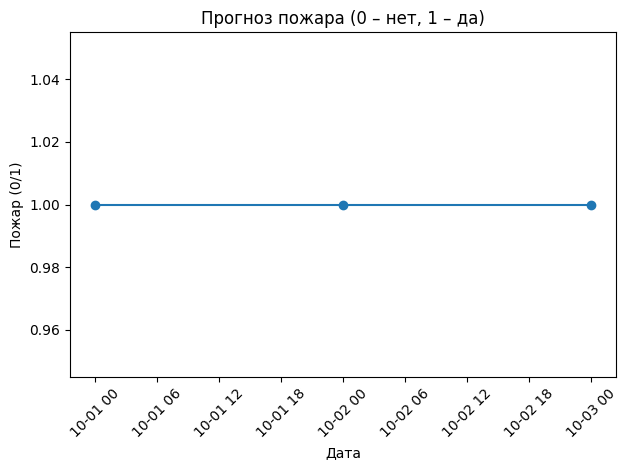

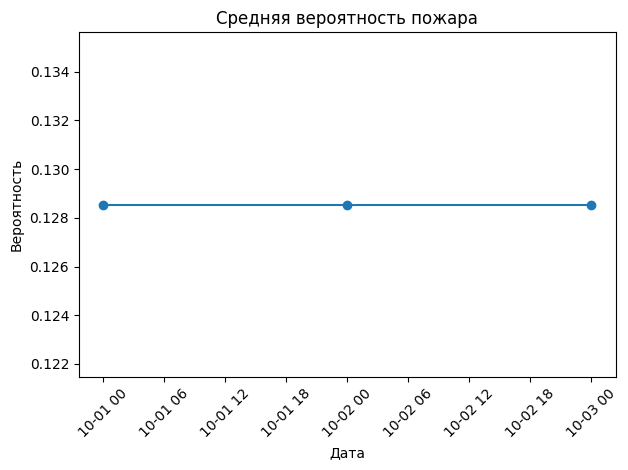

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Загрузка предсказаний
df = pd.read_csv('fire_predictions_next3days.csv', parse_dates=['day'])

# Аггрегация по дате: если есть хоть одно срабатывание пожара → 1, иначе 0;
# вероятность — среднее по всем объектам
agg = df.groupby('day').agg({
    'fire_pred': 'max',
    'fire_pred_prob': 'mean'
}).reset_index()

# График 1: дни и бинарный прогноз пожара
plt.figure()
plt.plot(agg['day'], agg['fire_pred'], marker='o', linestyle='-')
plt.title('Прогноз пожара (0 – нет, 1 – да)')
plt.xlabel('Дата')
plt.ylabel('Пожар (0/1)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# График 2: дни и средняя вероятность пожара
plt.figure()
plt.plot(agg['day'], agg['fire_pred_prob'], marker='o', linestyle='-')
plt.title('Средняя вероятность пожара')
plt.xlabel('Дата')
plt.ylabel('Вероятность')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline


In [ ]:

# --- данные ---
df = pd.read_csv('master_grid_post_eda_v1.csv', parse_dates=['Дата'])
df = df.sort_values('Дата').reset_index(drop=True)

# целевой столбец 0/1
df['Fire_Started_Today'] = df['Fire_Started_Today'].astype(int)

# --- лаги таргета (AR‑часть) ---
MAX_LAG = 3
for l in range(1, MAX_LAG+1):
    df[f'fire_lag_{l}'] = df['Fire_Started_Today'].shift(l)

# --- экзогенные признаки (пример) ---
exog_cols = [
    't_mean', 'humidity_mean', 'precip_total_day',
    'Added_Today_Tons', 'Removed_Today_Tons'
]
lag_cols = [f'fire_lag_{l}' for l in range(1, MAX_LAG+1)]
feature_cols = lag_cols + exog_cols

df = df.dropna(subset=feature_cols)  # из-за лагов первые строки отпадут

X = df[feature_cols]
y = df['Fire_Started_Today']

# --- cv по времени ---
tscv = TimeSeriesSplit(n_splits=5)

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(max_iter=500, class_weight='balanced'))
])

f1_scores = []
for train_idx, test_idx in tscv.split(X):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    print(classification_report(y_test, y_pred, digits=3))


              precision    recall  f1-score   support

           0      0.995     0.952     0.973     11504
           1      0.000     0.000     0.000        53

    accuracy                          0.948     11557
   macro avg      0.498     0.476     0.487     11557
weighted avg      0.991     0.948     0.969     11557

              precision    recall  f1-score   support

           0      0.995     0.847     0.915     11478
           1      0.015     0.342     0.029        79

    accuracy                          0.844     11557
   macro avg      0.505     0.594     0.472     11557
weighted avg      0.988     0.844     0.909     11557

              precision    recall  f1-score   support

           0      1.000     0.964     0.982     11557
           1      0.000     0.000     0.000         0

    accuracy                          0.964     11557
   macro avg      0.500     0.482     0.491     11557
weighted avg      1.000     0.964     0.982     11557

              preci

In [ ]:

# 2) Ставим нужные версии
!pip install --no-cache-dir \
  numpy==1.26.4 \
  packaging==24.3 \
  scipy==1.10.1 \
  statsmodels==0.14.2 \
  scikit-learn==1.4.2


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 16.9 MB/s eta 0:00:00
ERROR: Ignored the following yanked versions: 20.6
ERROR: Ignored the following versions that require a different python version: 1.21.2 Requires-Python >=3.7,<3.11; 1.21.3 Requires-Python >=3.7,<3.11; 1.21.4 Requires-Python >=3.7,<3.11; 1.21.5 Requires-Python >=3.7,<3.11; 1.21.6 Requires-Python >=3.7,<3.11
ERROR: Could not find a version that satisfies the requirement packaging==24.3 (from versions: 14.0, 14.1, 14.2, 14.3, 14.4, 14.5, 15.0, 15.1, 15.2, 15.3, 16.0, 16.1, 16.2, 16.3, 16.4, 16.5, 16.6, 16.7, 16.8, 17.0, 17.1, 18.0, 19.0, 19.1, 19.2, 20.0, 20.1, 20.2, 20.3, 20.4, 20.5, 20.7, 20.8, 20.9, 21.0, 21.1, 21.2, 21.3, 22.0, 23.0, 23.1, 23.2, 24.0, 24.1, 24.2, 25.0)
ERROR: No matching distribution found for packaging==24.3


In [ ]:
model = CatBoostClassifier()

model.load_model("/content/catboost_fire_model.cbm")

X_new = pd.read_csv(
    "/content/bum_upd.csv"
)

preds = model.predict_proba(X_new)

print("Предсказанные возгорания:", preds)

CatBoostError: Invalid cat_features[2] = 88 value: index must be < 16.